**Import Libraries**

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
sns.set(style="whitegrid")
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping




**Dataset**

In [2]:
df = pd.read_csv('HAM10000_metadata.csv')


Dataset Description: ISIC 2020 Training Ground Truth

File: ISIC_2020_Training_GroundTruth.csv  
Total Records: 33,126  
Number of Malignant (target=1): 584  
Number of Benign (target=0): 32,542  
Malignant Percentage: ~1.76% (highly imbalanced dataset)

Columns:

1. image_name (str)
   - Unique identifier for each dermoscopic image (e.g., "ISIC_2637011").
   - Used to map images to ground truth labels.

2. patient_id (str)
   - Encoded ID of the patient the image belongs to.
   - Useful for grouping or stratified sampling.

3. sex (str)
   - Values: 'male', 'female', or NaN
   - 33061 non-null entries; some missing values.

4. age_approx (float)
   - Approximate age of the patient in years.
   - Range: 0 to 90 years
   - 33058 non-null entries; some missing values.

5. anatom_site_general_challenge (str)
   - Anatomical site where lesion is located.
   - Examples: 'head/neck', 'upper extremity', 'lower extremity'
   - 32,599 non-null entries; some missing values.

6. diagnosis (str)
   - Medical diagnosis of the lesion (e.g., 'nevus', 'unknown')
   - Useful for subclassification if needed.

7. benign_malignant (str)
   - Class label indicating whether the lesion is benign or malignant.
   - Values: 'benign', 'malignant'

8. target (int)
   - Final binary classification label.
   - 1 = Malignant (Melanoma)
   - 0 = Benign

Statistical Summary:

- Average patient age: ~48.87 years
- Class Distribution:
    - Benign: 32,542 samples
    - Malignant: 584 samples
    - Note: Consider class balancing techniques (e.g., oversampling, augmentation, class weights)

Example Row:

| image_name   | patient_id | sex    | age_approx | anatom_site_general_challenge | diagnosis | benign_malignant | target |
|--------------|------------|--------|------------|-------------------------------|-----------|------------------|--------|
| ISIC_2637011 | IP_7279968 | male   | 45.0       | head/neck                    | unknown   | benign           | 0      |

Usage:
- This dataset can be used to train a binary classification model (e.g., CNN) to detect melanoma.
- Use 'image_name' to load images and 'target' as the label.
- Use other metadata (age, sex, site) for additional model features or analysis.

"""
**bold text** **bold text**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [4]:
df.head(20)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [5]:
df.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0000835,ISIC_0032258,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


Data Cleaning

In [6]:
# Count missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())



Missing values per column:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


In [7]:
# Fill missing 'age' with median
df['age'] = df['age'].fillna(df['age'].median())

# If any other column has NaNs (e.g., 'sex'), drop or fill
df['sex'] = df['sex'].fillna(df['sex'].mode()[0])
df['localization'] = df['localization'].fillna(df['localization'].mode()[0])


In [8]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Remove duplicates
df = df.drop_duplicates()



Number of duplicate rows: 0


In [9]:
# Check for typos or inconsistencies
for col in ['dx', 'sex', 'localization', 'dx_type']:
    print(f"\nUnique values in '{col}': {df[col].unique()}")



Unique values in 'dx': ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']

Unique values in 'sex': ['male' 'female' 'unknown']

Unique values in 'localization': ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']

Unique values in 'dx_type': ['histo' 'consensus' 'confocal' 'follow_up']


In [10]:
df['sex'] = df['sex'].str.strip().str.lower()
df['dx'] = df['dx'].str.strip().str.lower()
df['localization'] = df['localization'].str.strip().str.lower()


In [11]:
# Final null and shape check
print("\nNull values after cleaning:")
print(df.isnull().sum())

print(f"\nDataset shape after cleaning: {df.shape}")



Null values after cleaning:
lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

Dataset shape after cleaning: (10015, 7)


In [12]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [13]:
print("Data types before encoding:")
print(df.dtypes)

# Check again unique values for categorical columns
for col in ['dx', 'sex', 'localization', 'dx_type']:
    print(f"\nUnique values in {col}: {df[col].unique()}")


Data types before encoding:
lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

Unique values in dx: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']

Unique values in sex: ['male' 'female' 'unknown']

Unique values in localization: ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']

Unique values in dx_type: ['histo' 'consensus' 'confocal' 'follow_up']


ENCODING

In [14]:


label_encoders = {}
categorical_cols = ['sex', 'localization', 'dx_type']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [15]:

corr_df = df.copy()
categorical_cols = ['sex', 'localization', 'dx_type', 'dx']

# Apply label encoding
le = LabelEncoder()
for col in categorical_cols:
    corr_df[col] = le.fit_transform(corr_df[col])

SCALING

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['age_scaled'] = scaler.fit_transform(df[['age']])


In [17]:
# Select features (excluding 'image_id', 'dx_full')
feature_cols = ['age_scaled', 'sex', 'localization', 'dx_type']
X = df[feature_cols]

# Target (encoded 'dx')
y = df['dx']


In [18]:
# Mapping for full diagnosis names
diagnosis_map = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Add new column with full diagnosis
df['dx_full'] = df['dx'].map(diagnosis_map)


/tmp/ipython-input-2626935736.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='dx_full', order=df['dx_full'].value_counts().index, palette='Set2')


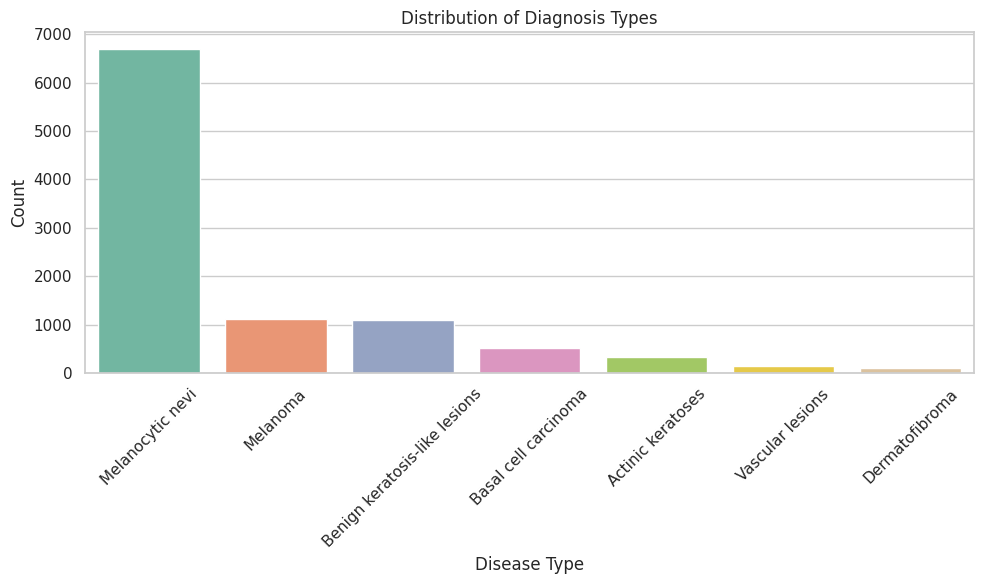

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='dx_full', order=df['dx_full'].value_counts().index, palette='Set2')
plt.title("Distribution of Diagnosis Types")
plt.xticks(rotation=45)
plt.xlabel("Disease Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


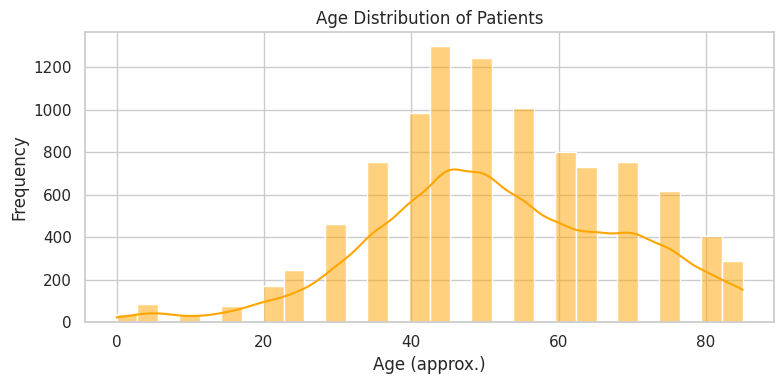

In [20]:
plt.figure(figsize=(8, 4))
sns.histplot(df['age'], kde=True, bins=30, color='orange')
plt.title("Age Distribution of Patients")
plt.xlabel("Age (approx.)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


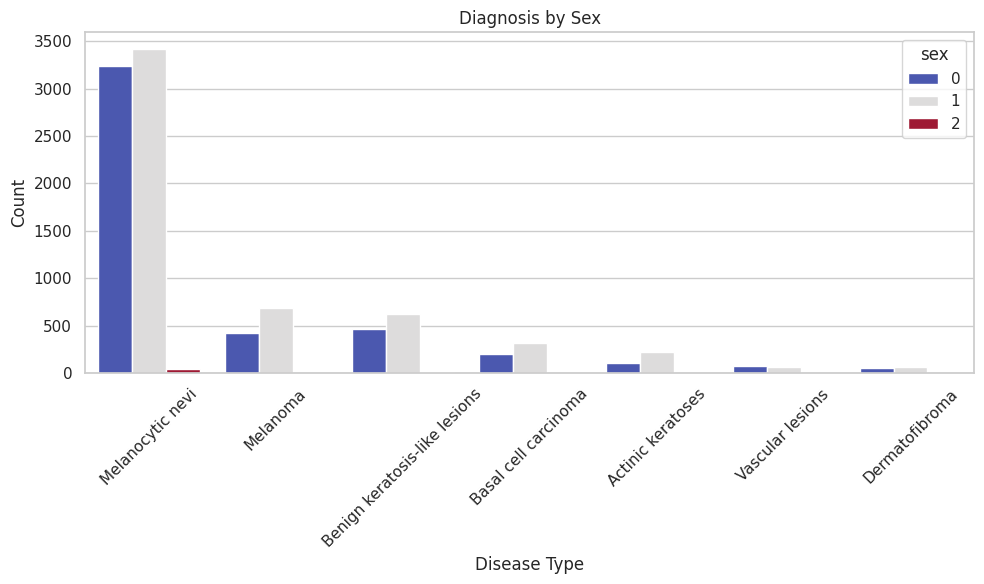

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='dx_full', hue='sex', order=df['dx_full'].value_counts().index, palette='coolwarm')
plt.title("Diagnosis by Sex")
plt.xlabel("Disease Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


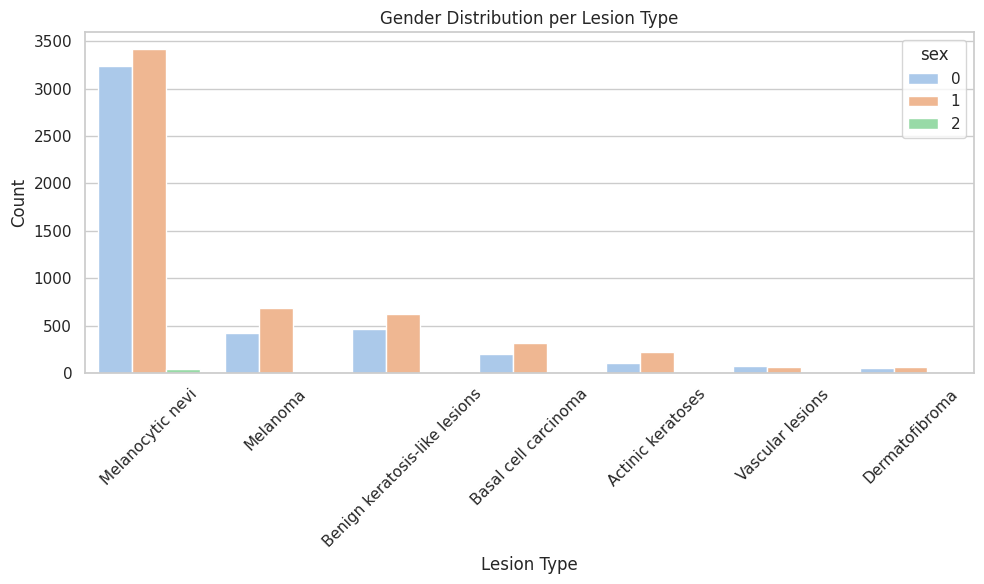

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='dx_full', hue='sex', palette='pastel', order=df['dx_full'].value_counts().index)
plt.title('Gender Distribution per Lesion Type')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-1912177945.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='dx_full', y='age', palette='coolwarm')


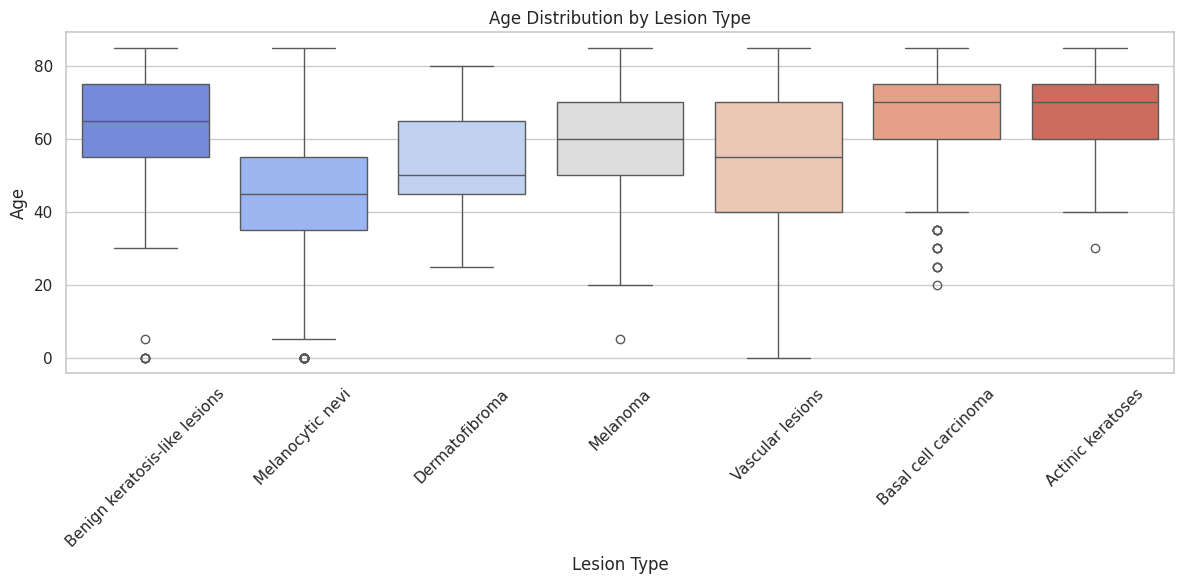

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='dx_full', y='age', palette='coolwarm')
plt.title('Age Distribution by Lesion Type')
plt.xlabel('Lesion Type')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


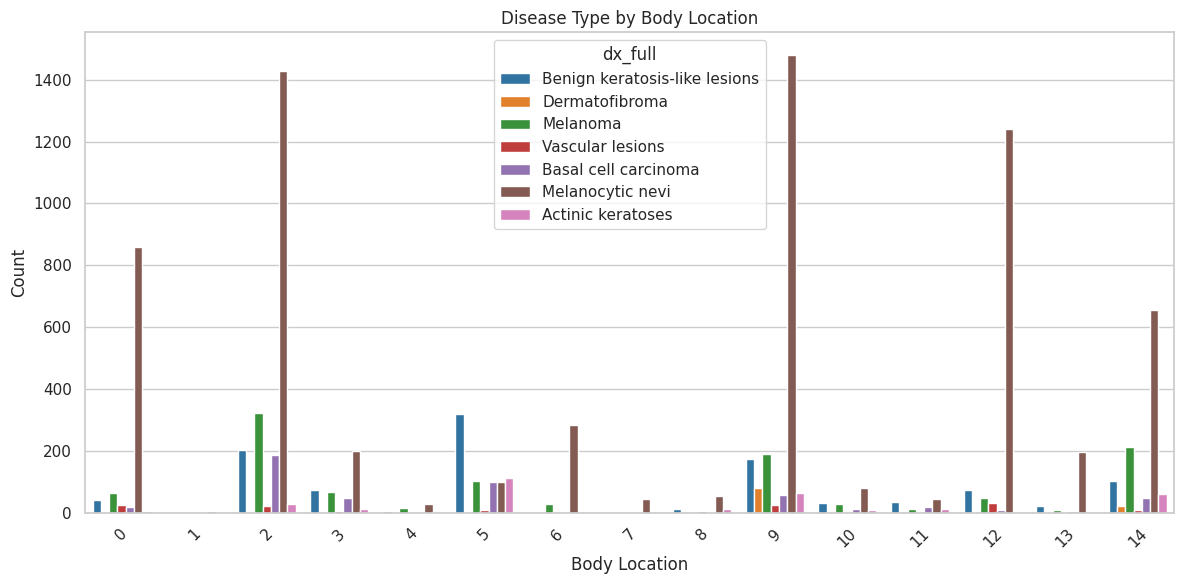

In [24]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='localization', hue='dx_full', palette='tab10')
plt.title("Disease Type by Body Location")
plt.xlabel("Body Location")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-1863443444.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='age_group', palette='BuPu')


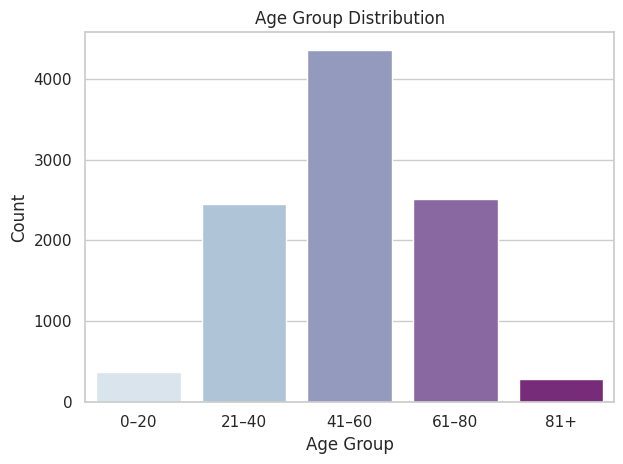

In [25]:
df['age_group'] = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, 100], labels=['0–20', '21–40', '41–60', '61–80', '81+'])
sns.countplot(data=df, x='age_group', palette='BuPu')
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


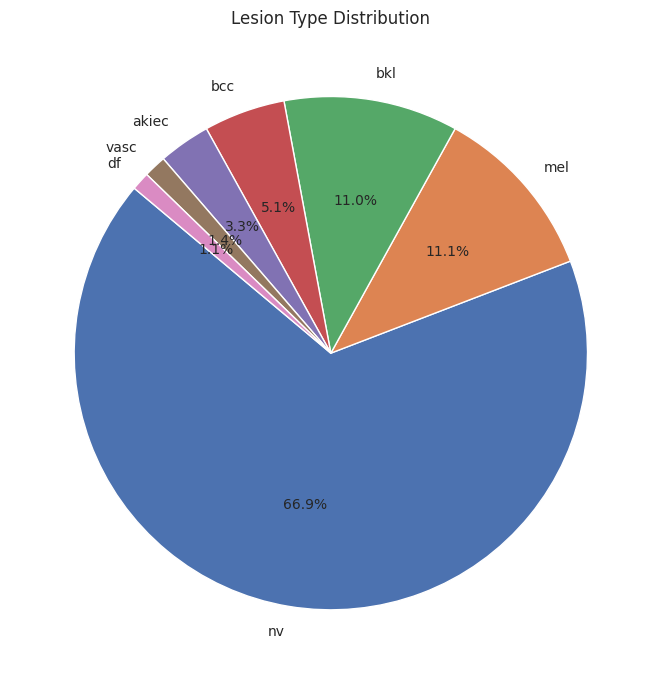

In [26]:
lesion_counts = df['dx'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(lesion_counts, labels=lesion_counts.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title('Lesion Type Distribution')
plt.tight_layout()
plt.show()


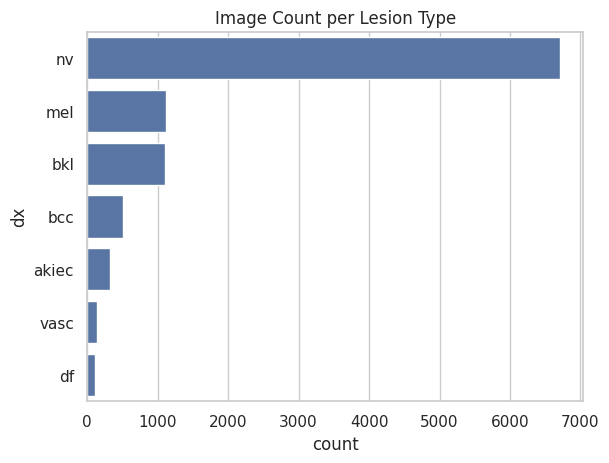

In [27]:
sns.countplot(y='dx', data=df, order=df['dx'].value_counts().index)
plt.title('Image Count per Lesion Type')
plt.show()


In [28]:
# Only keep numeric columns for correlation
corr = corr_df[['age_scaled', 'sex', 'localization', 'dx_type', 'dx']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


KeyError: "['age_scaled'] not in index"

In [29]:
from google.colab import files
import zipfile
import os

# Upload the zip file
uploaded = files.upload()

# Extract the ZIP file
for file_name in uploaded.keys():
    if file_name.endswith('.zip'):
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall('/content/images')
        print(f"✅ Extracted '{file_name}' to /content/images/")


Saving images.zip to images.zip
✅ Extracted 'images.zip' to /content/images/


In [35]:
import zipfile
import os

zip_path = 'images.zip'  # This is the uploaded zip path
extract_dir = '/content/images/images'    # Directory where we will extract

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Extraction done.")


✅ Extraction done.


In [36]:
# Check first 10 files
import os

files = os.listdir(extract_dir)
print(f"Total files: {len(files)}")
print("Sample files:", files[:10])


Total files: 93
Sample files: ['ISIC_0024341.jpg', 'ISIC_0024357.jpg', 'ISIC_0024318.jpg', 'ISIC_0024354.jpg', 'ISIC_0024311.jpg', 'ISIC_0024319.jpg', 'ISIC_0024350.jpg', 'ISIC_0024373.jpg', 'ISIC_0024342.jpg', 'ISIC_0024321.jpg']


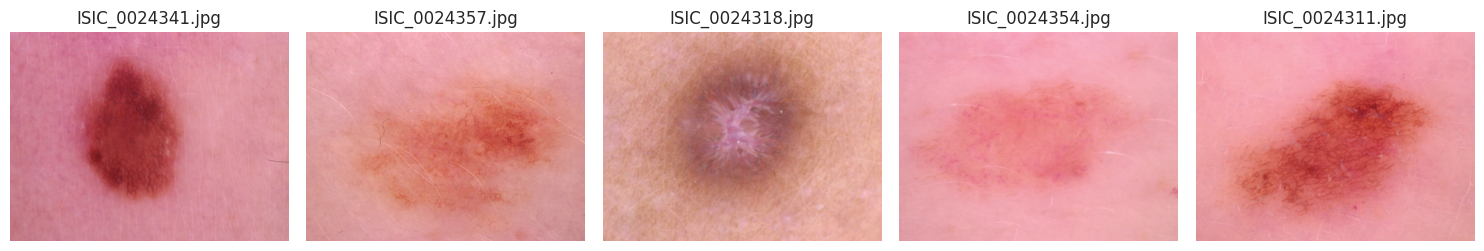

In [37]:
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

images_shown = 0
for file in files:
    if file.endswith('.jpg') or file.endswith('.png'):
        img_path = os.path.join(extract_dir, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, images_shown + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(file)

        images_shown += 1
        if images_shown == 5:
            break

plt.tight_layout()
plt.show()


Images found: (92, 12)
Image array shape: (92, 64, 64, 3)
Classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,999 (2.61 MB)

 Trainable params: 684,551 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 749ms/step - accuracy: 0.2916 - loss: 2.9227 - val_accuracy: 0.1053 - val_loss: 1.9631
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step - accuracy: 0.6162 - loss: 1.8292 - val_accuracy: 0.1053 - val_loss: 1.9065
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step - accuracy: 0.6680 - loss: 1.5168 - val_accuracy: 0.6842 - val_loss: 1.8255
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step - accuracy: 0.5950 - loss: 1.5736 - val_accuracy: 0.6842 - val_loss: 1.6555
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 0.7593 - loss: 0.7942 - val_accuracy: 0.6842 - val_loss: 1.5051
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - accuracy: 0.7722 - loss: 0.9537 - val_accuracy: 0.6842 - val_loss: 1.5311
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.6921 - loss: 1.1095 - val_accuracy: 0.6842 - val_loss: 1.6095
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.7165 - loss: 0.9647 - val_accuracy: 0.6842 - val_loss

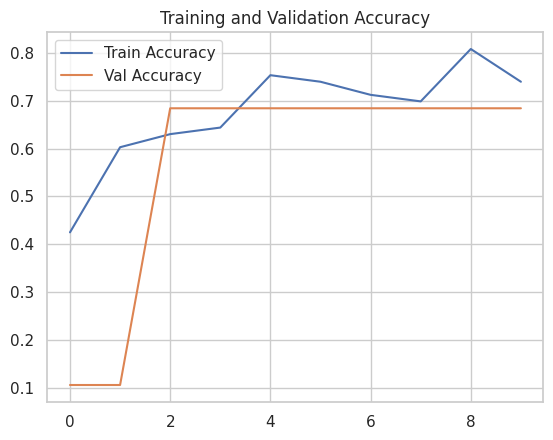

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
              precision    recall  f1-score   support

         bcc       0.00      0.00      0.00         1
         bkl       0.00      0.00      0.00         2
          df       0.00      0.00      0.00         1
         mel       0.00      0.00      0.00         2
          nv       0.68      1.00      0.81        13

    accuracy                           0.68        19
   macro avg       0.14      0.20      0.16        19
weighted avg       0.47      0.68      0.56        19



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


# ------------------ CHECK IMAGE PATH ------------------
# Assuming all images are in '/content/images/' directory
image_dir =  '/content/images/images'

# Check if all image files exist
df['path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
df = df[df['path'].apply(os.path.exists)]
print("Images found:", df.shape)

# ------------------ LOAD & RESIZE IMAGES ------------------
IMG_SIZE = 64
images = []

for path in df['path']:
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

X = np.array(images) / 255.0
print("Image array shape:", X.shape)

# ------------------ PREPARE LABELS ------------------
le = LabelEncoder()
y = le.fit_transform(df['dx'])
y_cat = to_categorical(y, num_classes=len(le.classes_))
print("Classes:", le.classes_)

# ------------------ TRAIN TEST SPLIT ------------------
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

# ------------------ IMAGE AUGMENTATION ------------------
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
datagen.fit(X_train)

# ------------------ MODEL ------------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ------------------ TRAIN ------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=25,
    callbacks=[early_stop]
)

# ------------------ PLOT ACCURACY ------------------
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# ------------------ EVALUATION ------------------
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)


# Recalculate unique labels from the true labels
unique_labels = np.unique(y_true)

# Use only target names that are actually present in y_true
print(classification_report(y_true, y_pred_labels, labels=unique_labels, target_names=le.inverse_transform(unique_labels)))


